<h1 style="text-align:center; color:#000080; font-weight:bold; font-size:38px;">Tornado Prediction</h1>

<h1 style="text-align:left; color:#00bfff; font-weight:bold; font-size:28px;">Import Libraries</h1>

In [1]:
# Cleaning and Viualization Libraries
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
# ml tools
from sklearn.preprocessing import (StandardScaler,
                                   MinMaxScaler,
                                   OrdinalEncoder,
                                   OneHotEncoder,
                                   RobustScaler,
                                   LabelEncoder,
                                   power_transform,
                                   FunctionTransformer)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import ( cross_val_predict,
                                     cross_val_score,
                                     train_test_split,
                                     GridSearchCV,
                                     StratifiedKFold,
                                    RandomizedSearchCV)

from sklearn.pipeline import Pipeline , make_pipeline
from scipy.stats import randint
from scipy import stats
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

In [3]:
# models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import (RandomForestClassifier,
                              GradientBoostingClassifier,
                              BaggingClassifier)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [4]:
# metrics
from sklearn.metrics import (accuracy_score,
                             f1_score,
                             roc_auc_score,
                             roc_curve,
                             log_loss,
                             classification_report,
                             confusion_matrix)

<h1 style="text-align:left; color:#00bfff; font-weight:bold; font-size:28px;">Remove Warnings</h1>

In [5]:
import warnings
warnings.simplefilter("ignore")

<h1 style="text-align:left; color:#00bfff; font-weight:bold; font-size:28px;"> Reading the data</h1>

In [6]:
df=pd.read_csv('us_tornado_dataset_1950_2021.csv')
df = df.loc[:, ['date', 'mag']]
df.head()

,date,mag
0,1950-01-03,3
1,1950-01-03,3
2,1950-01-03,1
3,1950-01-13,3
4,1950-01-25,2


<h1 style="text-align:left; color:#00bfff; font-weight:bold; font-size:28px;"> Data label</h1>

In [7]:
df['mag'].unique()

array([ 3,  1,  2,  4,  0,  5, -9], dtype=int64)

In [8]:
df.rename(columns={'mag': 'damage_level','st' : 'state'}, inplace=True)

In [9]:
df = df[df['damage_level'] != -9]

* ***These ranges are The Enhance Fujita Scale***
    * **F rating thru Jan 2007; EF rating after Jan 2007 (-9 if unknown rating)**
    * **EF0 :	65–85 mph	<span style='color:#000080;'>Light damage</span>**
    * **EF1 :	86–110 mph	<span style='color:#000080;'>Moderate damage</span>**
    * **EF2 :	111–135 mph	<span style='color:#000080;'>Considerable damage</span>**
    * **EF3 :	136–165 mph	<span style='color:#000080;'>Severe damage</span>**
    * **EF4 :	166–200 mph	<span style='color:#000080;'>Devastating damage</span>**
    * **EF5 :	>200 mph	<span style='color:#000080;'>Incredible damage</span>**

<h1 style="text-align:left; color:#00bfff; font-weight:bold; font-size:28px;"> Wind speed</h1>

In [10]:
df['wind_speed'] = df['damage_level'].replace({
    0: np.round(np.random.uniform(65.0, 85.0, size=len(df)), 2),
    1: np.round(np.random.uniform(86.0, 110.0, size=len(df)), 2),
    2: np.round(np.random.uniform(111.0, 135.0, size=len(df)), 2),
    3: np.round(np.random.uniform(136.0, 165.0, size=len(df)), 2),
    4: np.round(np.random.uniform(166.0, 200.0, size=len(df)), 2),
    5: np.round(np.random.uniform(201.0, 226.0, size=len(df)), 2),
    -9: np.round(np.random.uniform(555.0, 666.0, size=len(df)), 2)
})

In [11]:
df.shape

(66953, 3)

<h1 style="text-align:left; color:#00bfff; font-weight:bold; font-size:28px;"> Data Exploration</h1>

In [12]:
df.head()

,date,damage_level,wind_speed
0,1950-01-03,3,157.56
1,1950-01-03,3,163.67
2,1950-01-03,1,97.75
3,1950-01-13,3,164.59
4,1950-01-25,2,125.34


In [13]:
df['damage_level'].value_counts()

0    31375
1    22885
2     9517
3     2536
4      581
5       59
Name: damage_level, dtype: int64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66953 entries, 0 to 67557
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          66953 non-null  object 
 1   damage_level  66953 non-null  int64  
 2   wind_speed    66953 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.0+ MB


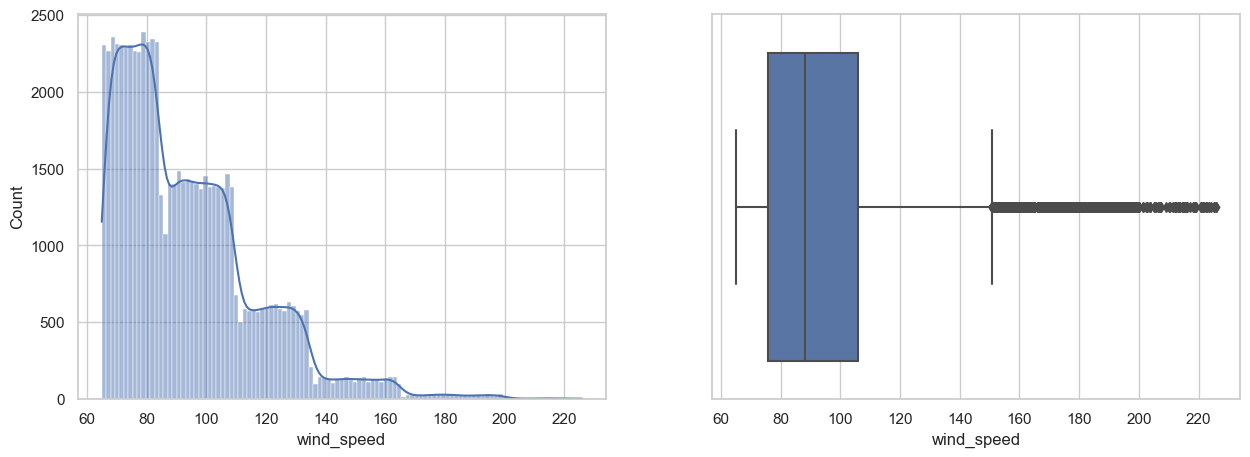

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=df, x="wind_speed", ax=axes[0],kde=True,palette="Blues")
sns.boxplot(data=df, x="wind_speed", ax=axes[1])

plt.show()

<Axes: xlabel='wind_speed', ylabel='damage_level'>

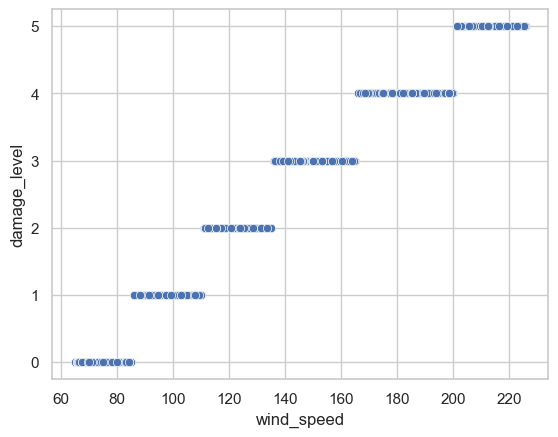

In [16]:
sns.scatterplot(data=df, x="wind_speed", y='damage_level')

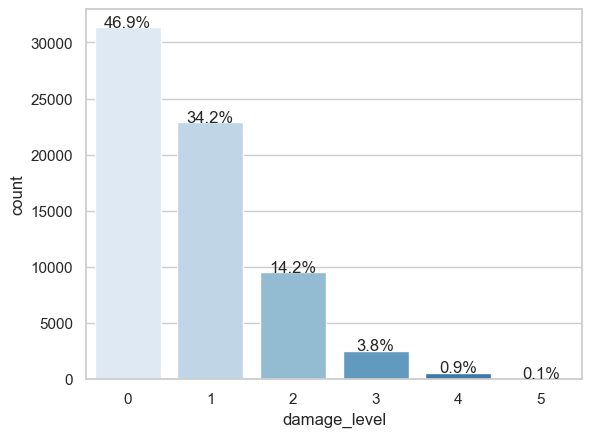

In [17]:
ax = sns.countplot(x="damage_level", data=df, palette="Blues")

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 5, f'{height / len(df):.1%}', ha="center")
plt.show()

In [18]:
df.skew()

damage_level    1.123833
wind_speed      1.284401
dtype: float64

<h1 style="text-align:left; color:#00bfff; font-weight:bold; font-size:28px;"> New Data After cleaning</h1>

* ***We fed new data to our original dataset to face the problem that faced use <span style='color:#000080;'>the imbalanced multiclasses</span>***

<h1 style="text-align:left; color:#00bfff; font-weight:bold; font-size:28px;">Our New Data</h1>

In [19]:
tornado=pd.read_csv('wind_df.csv')
tornado.head()

,damage_level,wind_speed
0,3,154.37
1,3,153.13
2,1,99.98
3,3,143.82
4,2,129.97


<h1 style="text-align:left; color:#00bfff; font-weight:bold; font-size:28px;">Our Exploration</h1>

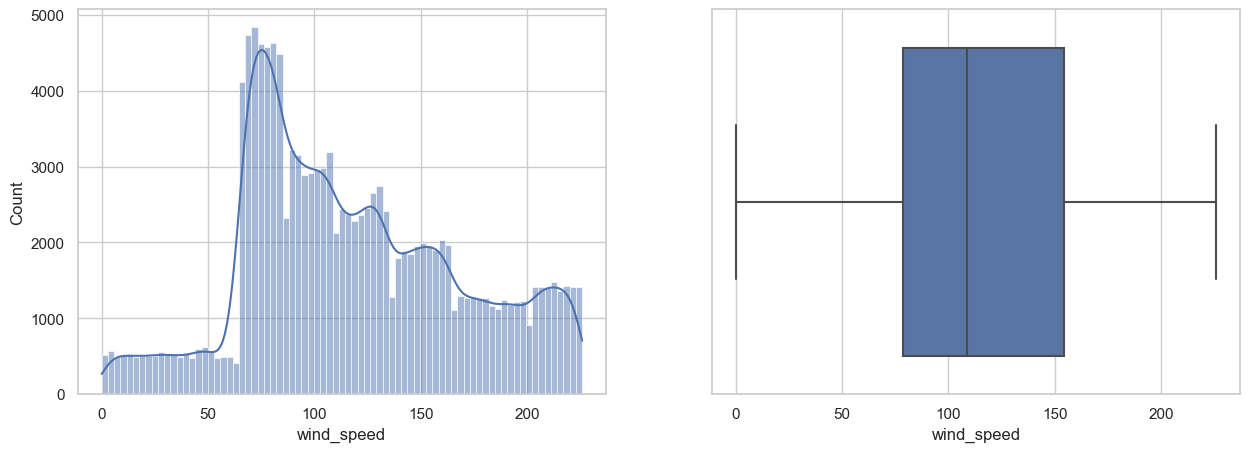

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=tornado, x="wind_speed", ax=axes[0],kde=True,palette="Blues")
sns.boxplot(data=tornado, x="wind_speed", ax=axes[1])

plt.show()

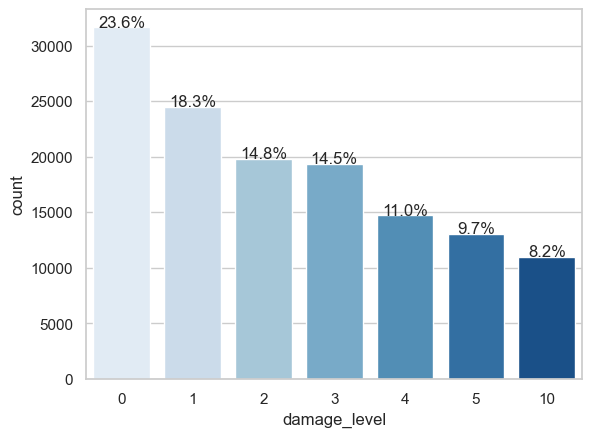

In [21]:
ax = sns.countplot(x="damage_level", data=tornado, palette="Blues")

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 5, f'{height / len(tornado):.1%}', ha="center")
plt.show()

In [22]:
tornado.skew()

damage_level    1.42401
wind_speed      0.26972
dtype: float64

<h1 style="text-align:left; color:#00bfff; font-weight:bold; font-size:28px;">Preprocessing</h1>

In [23]:
x = tornado.drop('damage_level',axis=1)
y = tornado[['damage_level']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

<h1 style="text-align:left; color:#00bfff; font-weight:bold; font-size:28px;">Modeling</h1>

* ***The most suitable baseline for our imbalanced data will be a model that blindly predicts the majority class.I will use sklearn <span style='color:#000080;'>DummyClassifier</span> for this purpose.***

In [24]:
# Create a baseline model
base = DummyClassifier(strategy="constant", constant=0)
accuracy_scores = cross_val_score(base, x_train, y_train, cv=5, scoring='accuracy')
dummy_accuracy = accuracy_scores
print(f"Your baseline model achieves average accuracy = {accuracy_scores.mean()}")

Your baseline model achieves average accuracy = 0.23585099094739337


In [25]:
models = [
    RandomForestClassifier(),
    LogisticRegression(),
    SGDClassifier()
]

In [26]:
best_model = None
best_score = 0 
best_y_pred = None

models_scores_cv = pd.DataFrame(columns=["accuracy"])

for model in models:
    cv_scores_acc = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy')
    mean_cv_score_acc = np.mean(cv_scores_acc)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    models_scores_cv.loc[model.__class__.__name__] = [mean_cv_score_acc]
    
    
    if mean_cv_score_acc > best_score: 
        best_score = mean_cv_score_acc
        best_model = model
        best_y_pred = y_pred  # Assign y_pred of the current best model

    print(f"{model.__class__.__name__} is Done.")

# Now, best_model will contain the best model, and best_y_pred will contain its predictions
print(f"The best model is: {best_model.__class__.__name__}")
print(f"The Accuracy of the best model is: {best_score}")

RandomForestClassifier is Done.
LogisticRegression is Done.
SGDClassifier is Done.
The best model is: RandomForestClassifier
The Accuracy of the best model is: 0.9642477851635324


In [27]:
models_scores_cv.sort_values(by = "accuracy", ascending = False)

,accuracy
RandomForestClassifier,0.964248
LogisticRegression,0.940227
SGDClassifier,0.431551


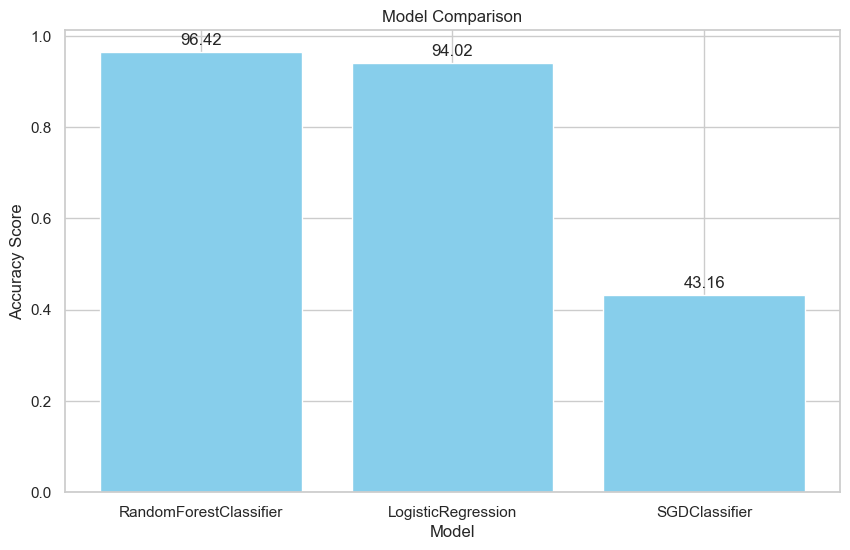

In [28]:
plt.figure(figsize=(10, 6))
bars = plt.bar(models_scores_cv.index, models_scores_cv["accuracy"], color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.title('Model Comparison')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval*100, 2), ha='center', va='bottom')

plt.show()

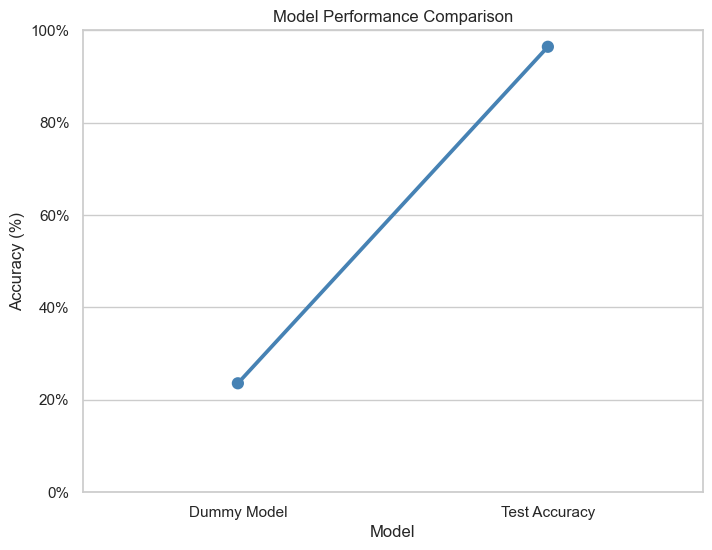

In [29]:
data = {
    'Model': ['Dummy Model', 'Test Accuracy', ],
    'Accuracy': [np.mean(dummy_accuracy), best_score ]
}
df = pd.DataFrame(data)
df['Accuracy'] *= 100
plt.figure(figsize=(8, 6))
sns.pointplot(x='Model', y='Accuracy', data=df, color='steelblue', markers='o')

plt.ylim(0, 100)  
plt.ylabel('Accuracy (%)')
plt.title('Model Performance Comparison')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter())

plt.show()

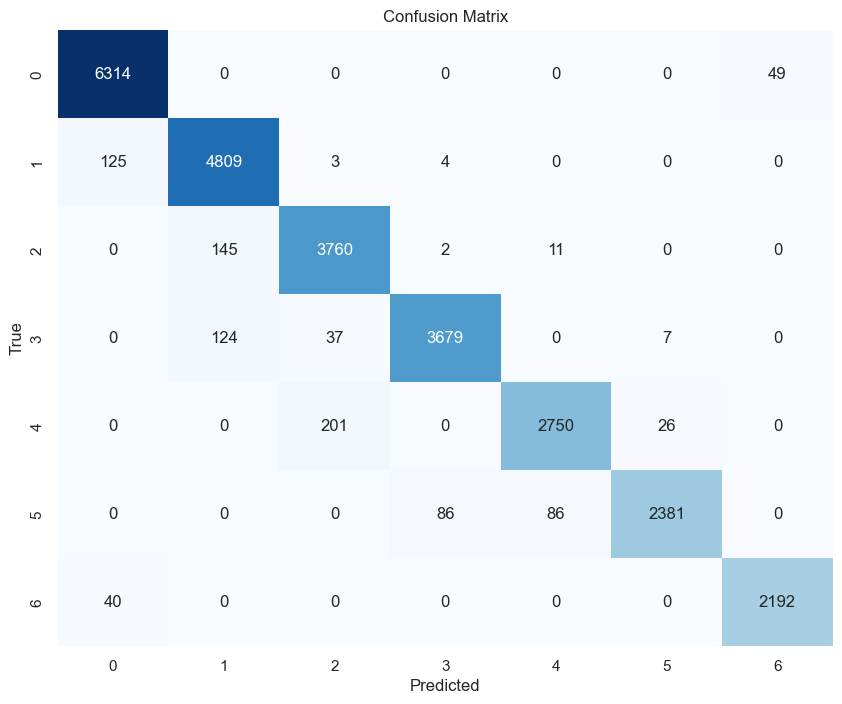

In [30]:
conf_mat = confusion_matrix(y_test, best_y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

<h1 style="text-align:left; color:#00bfff; font-weight:bold; font-size:28px;">Final Stage</h1>

In [31]:
np.unique(best_y_pred)

array([ 0,  1,  2,  3,  4,  5, 10], dtype=int64)

In [32]:
best_y_pred = pd.Series(best_y_pred)
best_y_pred = best_y_pred.replace({
    0: 'Light damage',
    1: 'Moderate damage',
    2: 'Considerable damage',
    3: 'Severe damage',
    4: 'Devastating damage',
    5: 'Incredible damage',
    10: 'No damage'
})

In [33]:
submission = pd.DataFrame({'Wind Speed': x_test.wind_speed.values, 'Tornado Damage': best_y_pred})
submission

,Wind Speed,Tornado Damage
0,141.74,Severe damage
1,79.12,Light damage
2,67.54,Light damage
3,81.62,Light damage
4,158.26,Severe damage
...,...,...
26826,147.81,Severe damage
26827,28.76,No damage
26828,175.66,Devastating damage
26829,101.69,Moderate damage


In [34]:
submission.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


<h1 style="text-align:left; color:#00bfff; font-weight:bold; font-size:28px;">Try Our Model</h1>

In [36]:
# Enter the I/P
user_input = input("\033[1;31mEnter the wind speed in mph\033[0m\n")

# The evaluation code to show the O/P
value = int(user_input)
sample = np.array([value])
sample_reshaped = sample.reshape(1, -1)
prediction = best_model.predict(sample_reshaped)

damage_mapping = {
    0: 'Light damage',
    1: 'Moderate damage',
    2: 'Considerable damage',
    3: 'Severe damage',
    4: 'Devastating damage',
    5: 'Incredible damage',
    10: 'No damage'
}

prediction_mapped = np.vectorize(damage_mapping.get)(prediction)

print(f"When the wind speed is \033[1;36m{sample[0]} mph\033[0m, we may encounter \033[1;34m{prediction_mapped[0]} tornado\033[0m")


Enter the wind speed in mph
123
When the wind speed is 123 mph, we may encounter Considerable damage tornado
